# Eye2sky network

In [1]:
import requests
import io
import os
import zipfile
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import warnings
# import tempfile
from itables import init_notebook_mode, show

## List of stations


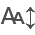

In [2]:
init_notebook_mode(all_interactive=False)

EYE2SKY_BASE_URL = 'https://zenodo.org/records/12804613/files/'

url = os.path.join(EYE2SKY_BASE_URL, 'Eye2Sky_Station_List.xlsx')

stations = pd.read_excel('https://zenodo.org/records/12804613/files/Eye2Sky_Station_List.xlsx')

show(stations, scrollY="500px", scrollCollapse=False, paging=False, classes="display",
     order=[[0, "asc"]], showIndex=False, columnDefs=[{"className": "dt-left", "targets": "_all"}])

In [3]:
import folium
from folium import plugins
import folium_legend

EsriImagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
EsriAttribution = "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community"

# Create Folium map
m = folium.Map(
    location=[53.23, 7.8],
    zoom_start=9, min_zoom=7, max_bounds=True,
    control_scale=True,  # Adds distance scale in lower left corner
    tiles='openstreetmap',
)

def _get_legend_color(station_type):
    if 'MET' in station_type:
        return 'magenta'
    elif 'REF' in station_type:
        return 'black'
    else:
        return 'cyan'

# Add each station to the map
for index, row in stations.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        tooltip=f"ID: {row['Station ID']} - Type: {row['Type']}",
        color=_get_legend_color(row['Type']),
        radius=6).add_to(m)

folium.raster_layers.TileLayer(EsriImagery, name='World imagery', attr=EsriAttribution, show=False).add_to(m)
folium.LayerControl(position='topright').add_to(m)
folium.LatLngPopup().add_to(m)  # Show latitude/longitude when clicking on the map
plugins.Fullscreen(position='bottomright').add_to(m)  # Add full screen button to map

# Create legend
legend_keys = ['REF', 'MET', 'Other']
legend_values = [_get_legend_color(s) for s in legend_keys]
legend = folium_legend.make_legend(legend_keys, legend_values, title="Station type")
m.get_root().html.add_child(legend)  # Add Legend to map

m

## Data availability

In [45]:
def get_eye2sky(station, start, end, file_type='cleaned', url=EYE2SKY_BASE_URL):
    """
    Retrieve ground-measured meteorological and solar irradiance data from the Eye2sky network.

    The Eye2Sky network [1]_ consists of 29 all-sky imager stations, of which 12 are equipped 
    with meteorological sensors in the northwest of Germany. Instrumentation at stations varies, 
    while all measure global horizontal irradiance, tilted irradiance, as well as temperature and humidity.
    Several stations measure diffuse horizontal and direct normal irradiance with a rotating shadowband irradiometer.
    Two Tier 1 stations have solar trackers measuring global, direct, and diffuse irradiance with thermopile sensors.

    Data is provided in two ways:
    1. Raw data, including quality flags from an in-house quality control procedure
    2. Cleaned data where data failing the quality control procedure has been removed

    Additionally, clear sky irradiance data and relative solar positions used for the QC are provided.

    Temporal resolution is 1 minute.
    
    Data is available from Zenodo [2]_.

    Parameters
    ----------
    station: str or list
        Station ID (5-digit ID). All stations can be requested by specifying
        station='all'.
    start: datetime-like
        First day of the requested period
    end: datetime-like
        Last day of the requested period
    file_type: str, default : 'cleaned'
        Data version: "flagged" (L0 - raw + flags) or "cleaned" (L1 - based on QC)

    Returns
    -------
    data: xarray Dataset
        Dataset of timeseries data from the Eye2Sky measurement network.

    Warns
    -----
    UserWarning
        If one or more requested files are missing, a UserWarning is returned.

    Examples
    --------
    >>> # Retrieve 2 weeks of data from Eye2Sky station OLWIN
    >>> data = get_eye2sky('OLWIN','2022-05-21','2022-07-21', type="cleaned")  # doctest: +SKIP

    References
    ----------
    .. [1] `Schmidt, Thomas; Stührenberg, Jonas; Blum, Niklas; Lezaca, Jorge; Hammer, Annette; Vogt, Thomas (2022)
            A network of all sky imagers (ASI) enabling accurate and high-resolution very short-term forecasts of solar irradiance**. 
            In: Wind & Solar Integration Workshop. IET Digital Library. 21st Wind & Solar Integration Workshop, 12.14. Okt. 2022, The Hague, Netherlands. 
            DOI: 
            <https://doi.org/10.1049/icp.2022.2778/>`_ 
    .. [2] `Zenodo
       <https://zenodo.org/records/12804613>`_ 
    """
    zipped_archive_url = os.path.join(EYE2SKY_BASE_URL, f"{station}.zip")

    response = requests.get(zipped_archive_url)

    zip_data = io.BytesIO(response.content)

    with zipfile.ZipFile(zip_data, "r") as zip_file:
        # List all files in the ZIP archive
        # print(zip_file.namelist())

        filename = f"data/{station}.{file_type}.nc"

        # Open a specific file inside the ZIP without extracting
        with zip_file.open(filename) as nc_file:
            nc_data = io.BytesIO(nc_file.read())  # Load NetCDF file into memory
            ds = xr.load_dataset(nc_data).sel(time=slice(start, end))

    return ds

In [46]:
data = get_eye2sky('OLWIN', '2022-07-21', '2022-07-26', file_type='cleaned')

https://zenodo.org/records/12804613/files/OLWIN.zip


<Axes: xlabel='time'>

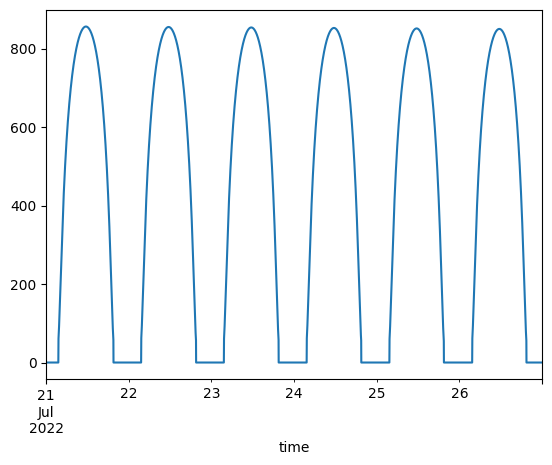

In [47]:
data.to_dataframe()['cDNI'].plot()

### What is returned?

In [48]:
data

<xarray.Dataset> Size: 899kB
Dimensions:       (time: 8640)
Coordinates:
  * time          (time) datetime64[ns] 69kB 2022-07-21 ... 2022-07-26T23:59:00
    latitude      float64 8B 53.15
    longitude     float64 8B 8.162
    elevation     int64 8B 15
Data variables: (12/14)
    cDNI          (time) float64 69kB -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
    RH            (time) float64 69kB 75.0 76.0 76.0 76.0 ... 82.0 82.0 82.0
    cGHI          (time) float64 69kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    RAIN          (time) float64 69kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    turbidity     (time) float64 69kB 3.625 3.625 3.625 ... 3.665 3.665 3.665
    SAZ           (time) float64 69kB 6.399 6.642 6.885 ... 5.702 5.949 6.195
    ...            ...
    T             (time) float64 69kB 20.2 20.2 20.2 20.2 ... 12.4 12.4 12.4
    DHI           (time) float64 69kB -0.0 0.0 0.1 0.0 ... -0.2 -0.1 -0.1 -0.0
    cDHI          (time) float64 69kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SZA           (time) float64 69kB 106.1 106.1 106.1 ... 107.4 107.4 107.4
    station_name  <U5 20B 'OLWIN'
    crs           int64 8B -999
Attributes: (12/36)
    grid_mapping_name:            latitude_longitude
    longitude_of_prime_meridian:  0.0
    semi_major_axis:              6378137.0
    inverse_flattening:           298.257223563
    epsg_code:                    EPSG:4326
    title:                        Timeseries of solar irradiance and meteorol...
    ...                           ...
    height:                       15
    license:                      https://cdla.dev/sharing-1-0/
    qc_level:                     quality controlled + cleaned data
    surface_type:                 roof,pebbles
    topography_type:              flat
    rural_urban:                  suburban

### Data attributes

In [49]:
data.attrs

{'grid_mapping_name': 'latitude_longitude',
 'longitude_of_prime_meridian': '0.0',
 'semi_major_axis': '6378137.0',
 'inverse_flattening': '298.257223563',
 'epsg_code': 'EPSG:4326',
 'title': 'Timeseries of solar irradiance and meteorological measurements in Eye2Sky network from station: OLWIN',
 'summary': 'Measurements from ground-based instruments from the Eye2Sky network. The network is operated by DLR Institute of Networked Energy Systems in Oldenburg. First stations are measuring since 2018.',
 'keywords': 'solar irradiance, air temperature, relative humidity, meteorology, atmospheric radiation, measurement station',
 'featureType': 'timeSeries',
 'network_id': 'Eye2Sky',
 'platform': 'Eye2Sky',
 'network_region': 'North-West Germany',
 'station_country': 'Germany',
 'creator_name': 'Jonas Stührenberg (jonas.stuehrenberg@dlr.de)',
 'publisher_email': 'jonas.stuehrenberg@dlr.de,th.schmidt@dlr.de',
 'publisher_name': 'Thomas Schmidt',
 'publisher_institution': 'DLR Deutsches Luft-

### Which variables exist?

In [50]:
data.variables

Frozen({'cDNI': <xarray.Variable (time: 8640)> Size: 69kB
array([-0., -0., -0., ..., -0., -0., -0.])
Attributes:
    DIMENSION_LABELS:         time
    long_name:                modelled clear sky direct normal irradiance
    standard_name:            clear_sky_dni
    abbreviation:             cDNI
    units:                    W m-2
    _valid_min_:              0
    _valid_max_:              3000
    grid_mapping:             crs
    least_significant_digit:  1, 'RH': <xarray.Variable (time: 8640)> Size: 69kB
array([75., 76., 76., ..., 82., 82., 82.])
Attributes: (12/15)
    DIMENSION_LABELS:         time
    orig_name:                relative humidity
    interval_type:            left_closed/right_open/label_right
    meas_type:                mean
    sensor_brand:             Campbell Scientific
    sensor_model:             CS215
    ...                       ...
    abbreviation:             RH
    units:                    %
    _valid_min_:              0
    _valid_max_:  

In [51]:
data['GHI'].attrs

{'DIMENSION_LABELS': 'time',
 'orig_name': 'reference global irradiance',
 'interval_type': 'left_closed/right_open/label_right',
 'meas_type': 'avg',
 'sensor_brand': 'EKO',
 'sensor_model': 'MS-80',
 'sensor_type': 'thermopile pyranometer',
 'long_name': 'Global Horizontal Irradiance',
 'standard_name': 'surface_downwelling_shortwave_flux_in_air',
 'abbreviation': 'GHI',
 'units': 'W m-2',
 'valid_min_': np.float64(0.0),
 'valid_max_': np.int64(3000),
 'grid_mapping': 'crs',
 'least_significant_digit': np.int64(1)}

## Visualize data

### Show GHI of all stations and a single day in one graph

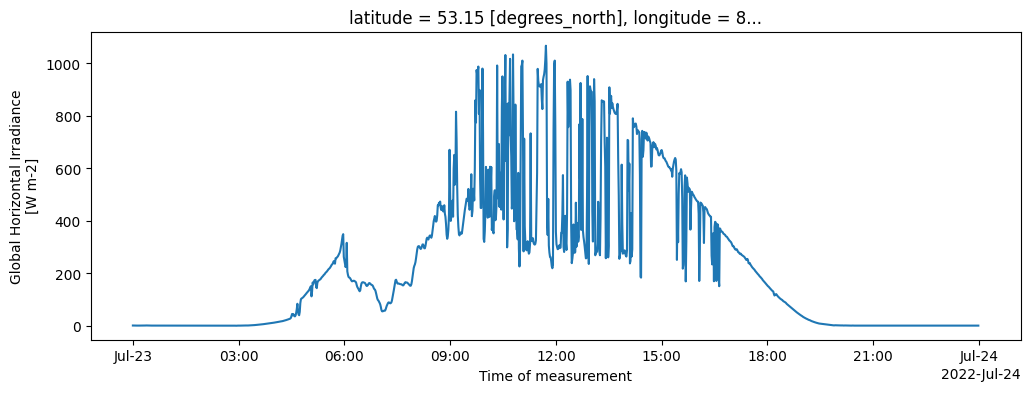

In [52]:
plt.figure(figsize=(12,4)) 
data['GHI'].sel(time='2022-07-23').plot()
plt.show()

### Show only 2 hours

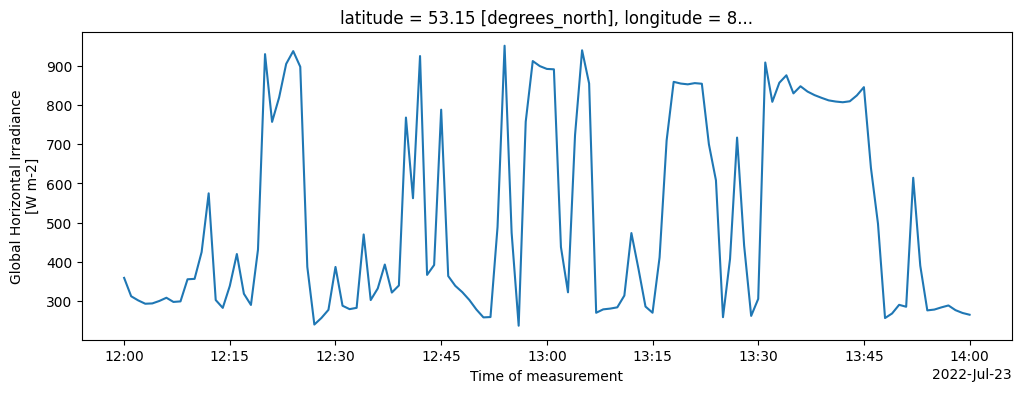

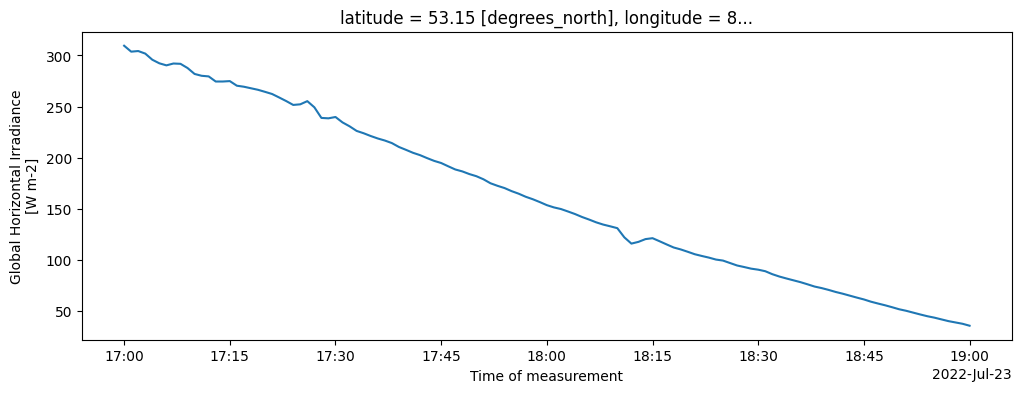

In [53]:
plt.figure(figsize=(12,4)) 
data['GHI'].sel(time=slice('2022-07-23T12:00:00', '2022-07-23T14:00:00')).plot()
plt.show()

plt.figure(figsize=(12,4)) 
data['GHI'].sel(time=slice('2022-07-23T17:00:00', '2022-07-23T19:00:00')).plot()
plt.show()

# The three components of station OLWIN

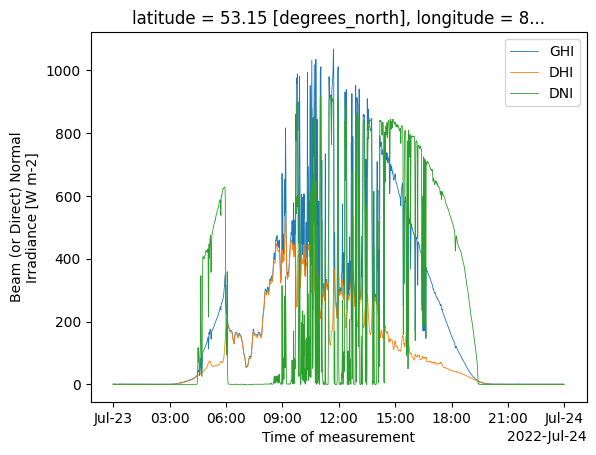

In [54]:
plt.figure()
data['GHI'].sel(time='2022-07-23').plot(lw=0.6, label="GHI")
data['DHI'].sel(time='2022-07-23').plot(lw=0.6, label="DHI")
data['DNI'].sel(time='2022-07-23').plot(lw=0.6, label="DNI")
plt.legend()
plt.show()

### Compare GHI measurements with the sum of diffuse and direct measurements

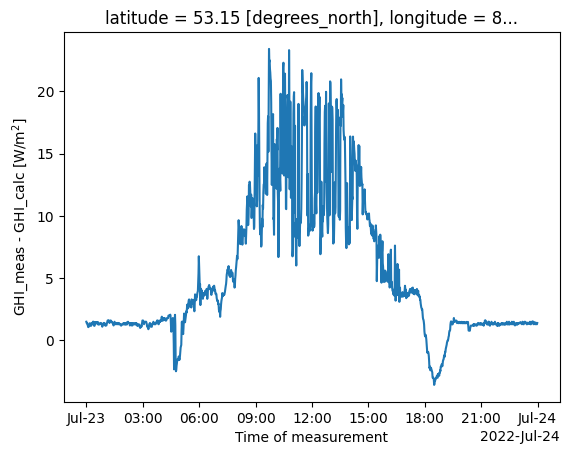

In [55]:
ghi = data['GHI'].sel(time='2022-07-23')
dhi = data['DHI'].sel(time='2022-07-23')
dni = data['DNI'].sel(time='2022-07-23')
solar_zenith = data['SZA'].sel(time='2022-07-23')
ghi_calc = dhi + dni * np.cos(np.radians(solar_zenith))

plt.figure()
(ghi -  ghi_calc).plot()
plt.ylabel('GHI_meas - GHI_calc [W/m$^2$]')
plt.show()

## Lets have a look in the raw data and QC flags

In [56]:
data = get_eye2sky(
    station='WITTM',
    start='2022-07-21',
    end='2022-07-25',
    file_type='flagged',
)

https://zenodo.org/records/12804613/files/WITTM.zip


### See the DNI flags

In [57]:
par = 'DNI'

# Test Names
qc_name = data[f'{par}.flag'].attrs['name'].split(',')
# Test Codes 
qc_code = data[f'{par}.flag'].attrs['code'].split(',')
# Test actions (how is data that failed tests treated in the cleaned data file)
qc_action = data[f'{par}.flag'].attrs['l1_action'].split(',')
# A description / long name of each test
qc_desc = data[f'{par}.flag'].attrs['description'].split(',')

tests = pd.DataFrame([qc_name, qc_code, qc_action], index=['Name', 'Code', 'Action'])
show(tests)

### Show the timeseries of flag values

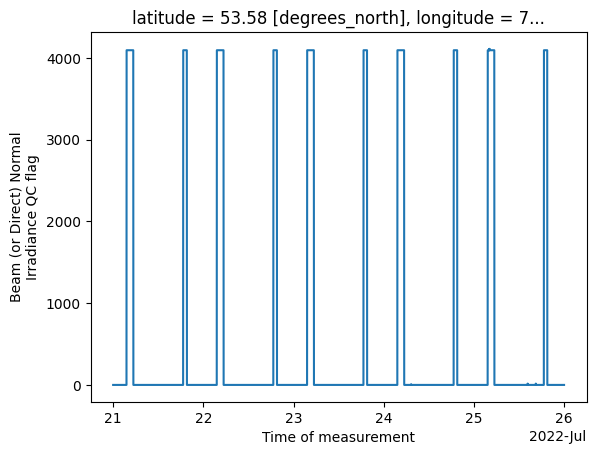

In [58]:
data[f'{par}.flag'].plot()

### Decode the Flags and make them human-readable

In [60]:
# This function decodes flag decimal value and returns a dictionary of boolean True/False for each single test
def decoding_flgs(dset, test_names):
    # Number of tests (code 0 == valid is not counting)
    tests = test_names[1:]
    ntests = len(tests)
    dec = np.copy(dset)
    flgs = (np.repeat(np.zeros(ntests), len(dec))).reshape(len(dec), ntests)
    for i in range(0, len(dec)):
        for j in range(0, len(flgs[i])):
            flgs[i][j] = dec[i] % 2
            dec[i] = dec[i] // 2
    df = {}
    for i, col in enumerate(tests):
        df[col] = flgs[:,i].astype(bool)
    return df

In [61]:
# Decode also the .test variable. It contains information if the test has been applied to the parameter or not
flags = data[f'{par}.flag']
tests = data[f'{par}.test']
tests = decoding_flgs(tests, qc_desc)
flags = decoding_flgs(flags, qc_desc)

### Print some statistics

In [64]:
# Print statistics
for key, value in flags.items():
    # only if test has been applied
    if all(tests[key]):
        if any(value):
            # Check for flags
            ind = value == True
            # Check for consecutive flags (-> periods)
            ind = np.diff(ind,prepend=False)
            periods = data['time'][ind].values.reshape(int(np.sum(ind)/2),2)
            print(f'QC failed for test "{key}"')
            print(f'Number of data points {len(periods)} ({100*len(periods)/len(data['time']):.2f} %)')
            #for i in range(periods.shape[0]):

QC failed for test "tracking error"
Number of data points 1 (0.01 %)
QC failed for test "two redundant measurements deviate from each other"
Number of data points 5 (0.07 %)
QC failed for test "shading based on horizon file"
Number of data points 10 (0.14 %)


### Make a plot for each single test

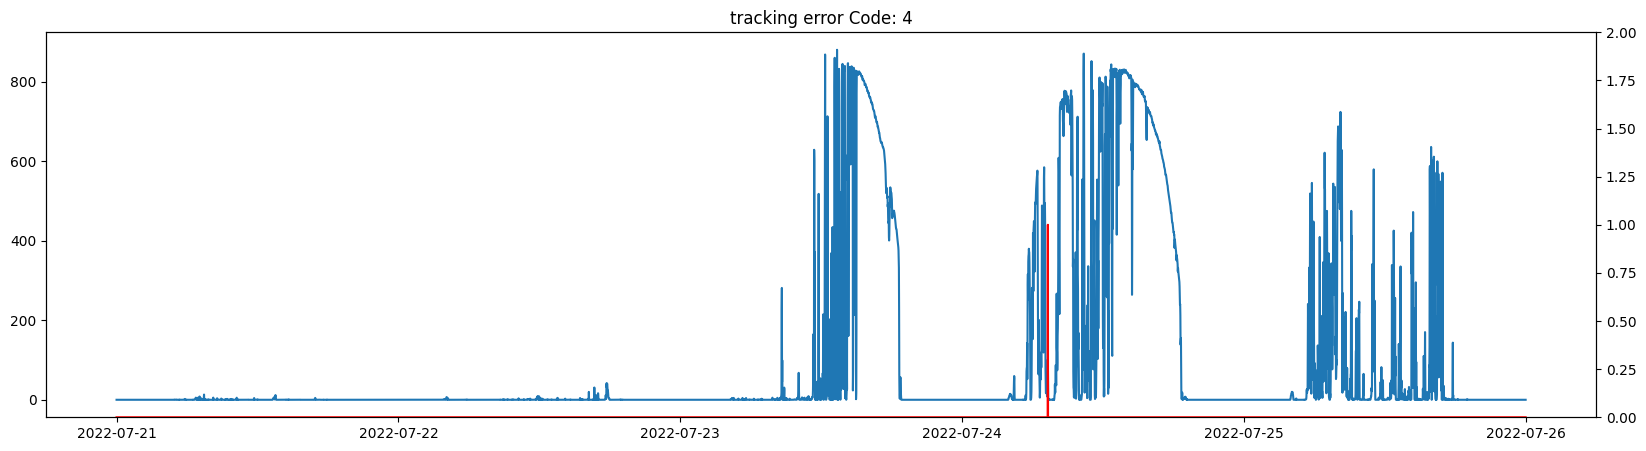

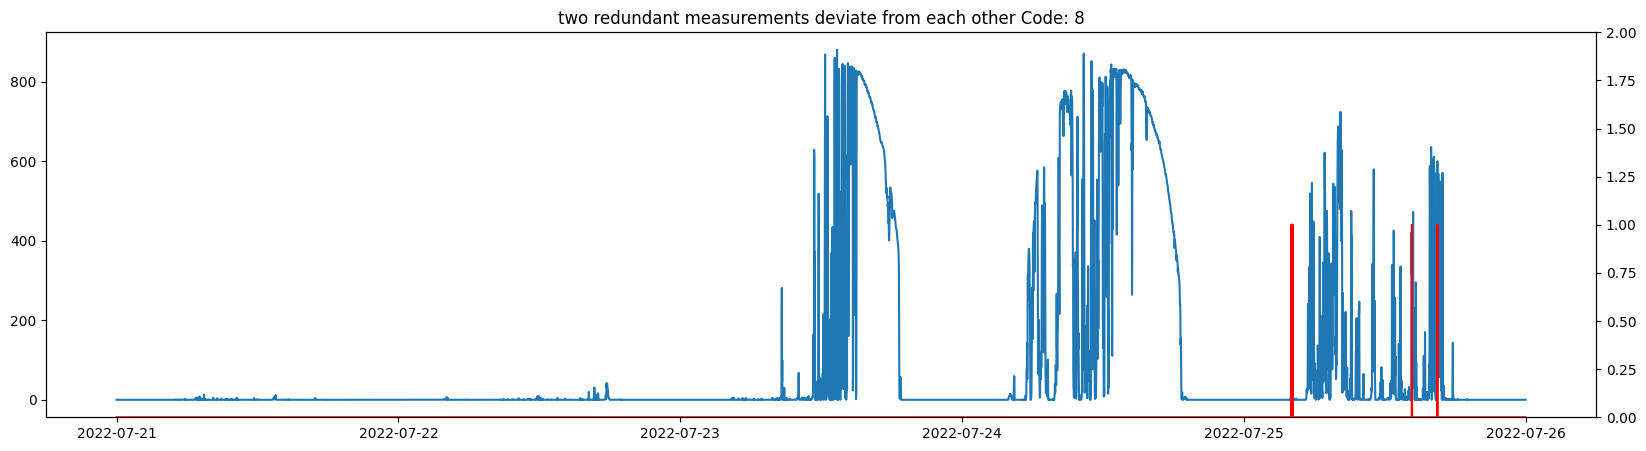

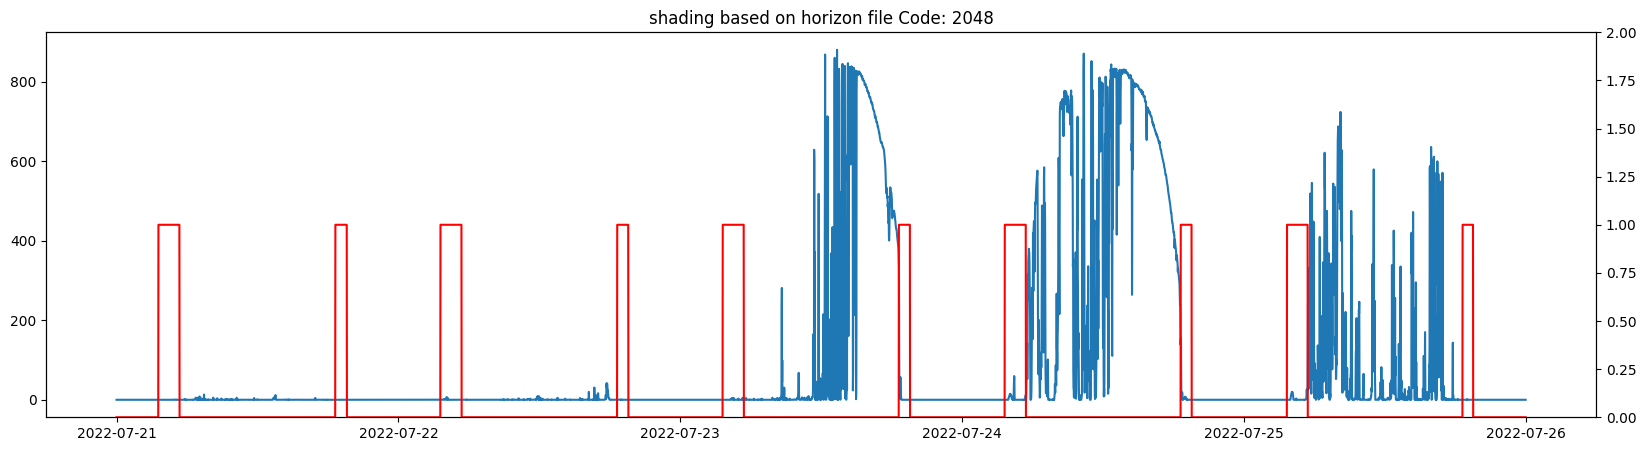

In [66]:
# Plot graphs
import matplotlib.pyplot as plt
for idx, (key, value) in enumerate(flags.items()):
    if all(tests[key]):
        if any(value):
            fig, ax = plt.subplots(figsize=(20,5))
            ax2 = ax.twinx()
            ax.plot(data['time'], data[par])
            ax2.plot(data['time'], value, c="r")
            ax2.set_ylim(0,2)
            plt.title(f'{key} Code: {qc_code[idx]}')
            plt.show()